# Evaluación del caso “Trío no colineal con planeta errante”

Exploramos un sistema de tres cuerpos inicialmente no colineales: dos estrellas masivas y un planeta errante que parte con desplazamiento lateral. Buscamos combinaciones de masa que reduzcan la sensibilidad caótica y mantengan la órbita del planeta dentro de un lazo estable durante integraciones largas.

> **Interpretación**
> - Un λ reducido indica que el planeta soporta mejor las perturbaciones y permanece ligado al sistema.
> - La penalización de periodicidad ayuda a mantener la topología orbital tras miles de unidades de tiempo, evitando salidas balísticas.


## Preparación del entorno

Localizamos la carpeta raíz `two_body`, la añadimos a `sys.path` y exponemos `PARENT` para reutilizar módulos comunes del repositorio. Garantizamos que los imports funcionen sin importar la ruta desde la que se ejecute el notebook.


In [61]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
while PROJECT_ROOT.name != "two_body" and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

if PROJECT_ROOT.name != "two_body":
    raise RuntimeError("No se encontró la carpeta two_body")

PARENT = PROJECT_ROOT.parent  # directorio que contiene a two_body
if str(PARENT) not in sys.path:
    sys.path.insert(0, str(PARENT))

print("PYTHONPATH += ", PARENT)


PYTHONPATH +=  C:\Users\emicr\Documents\CODIGOS_FUENTES\TrabajoTerminal\collision_of_two_bodies


## Dependencias principales
Importamos los componentes clave del pipeline:
- `Config` y utilidades de seeding.
- El controlador híbrido (GA + refinamiento).
- Herramientas de visualización y simulación REBOUND.
- `numpy` para cualquier análisis adicional.


In [62]:
from two_body import Config, set_global_seeds
from two_body.core.telemetry import setup_logger
from two_body.logic.controller import ContinuousOptimizationController
from two_body.presentation.visualization import Visualizer as PlanarVisualizer
from two_body.presentation.triDTry import Visualizer as Visualizer3D
from two_body.simulation.rebound_adapter import ReboundSim
import numpy as np
from pathlib import Path  # si quieres guardar animaciones/figuras


## Instrumentación de rendimiento

Activamos las variables de entorno de la suite de timings y cargamos `time_block`, `latest_timing_csv`, etc. Esto nos permitirá auditar qué tan costosa es cada fase (integración short/long, refinamiento continuo, métricas).


In [63]:
import os
os.environ["PERF_TIMINGS_ENABLED"] = "1"
os.environ.setdefault("PERF_TIMINGS_JSONL", "0")

from two_body.perf_timings.timers import time_block
from two_body.perf_timings import latest_timing_csv, read_timings_csv, parse_sections_arg, filter_rows


## Logging amigable para notebooks

Definimos un `NotebookHandler` que acumula los mensajes del optimizador y los muestra en vivo dentro de la celda. Mantiene la salida legible mientras corren las generaciones y el refinamiento continuo.


In [64]:
import logging
from IPython.display import display, Markdown

class NotebookHandler(logging.Handler):
    def __init__(self):
        super().__init__()
        self.lines = []

    def emit(self, record):
        msg = self.format(record)
        self.lines.append(msg)
        print(msg)  # aparece en la celda conforme avanza

handler = NotebookHandler()
handler.setFormatter(logging.Formatter("[%(asctime)s] %(levelname)s - %(message)s"))

logger = setup_logger(level="DEBUG")
logger.handlers.clear()          # quita otros handlers previos
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)


## Configuración del escenario “Trío no colineal”

El diccionario `case` establece:
- Integraciones prolongadas (`t_end_long = 12000`, `dt = 0.06`) con `whfast`.
- Condiciones iniciales no colineales: dos estrellas desplazadas y un planeta errante cerca del eje Y.
- Rangos de masa relativamente amplios para permitir que el GA redistribuya masa entre los tres cuerpos.
- Parámetros evolutivos moderados (`pop_size = 110`, `mutation = 0.08`, etc.) y penalización de periodicidad (`periodicity_weight = 0.1`) para favorecer órbitas reincidentes.


In [ ]:
two_pi = 2 * np.pi  # para dejarlo claro
cases = {
    "G": 4 * np.pi**2,            # unidades astronómicas (UA, años, masas solares)
    "r0": (
        (0.0, 0.0, 0.0),          # Sol
        (1.0, 0.0, 0.0),          # Tierra
        (5.2, 0.0, 0.0),          # Júpiter
    ),
    "v0": (
        (0.0, 0.0, 0.0),
        (0.0, two_pi, 0.0),                     # 1 órbita/año
        (0.0, two_pi / np.sqrt(5.2), 0.0),      # ≈ 2.753 UA/año
    ),

    # Masas fijas
    "mass_bounds": (
        (1.0, 1.0),              # Sol
        (3.0e-6, 3.0e-6),        # Tierra
        (9.5e-4, 9.5e-4),        # Júpiter
    ),

    # GA desactivado
    "pop_size": 1,
    "n_gen_step": 1,
    "mutation": 0.0,
    "crossover": 0.0,
    "elitism": 1,
    "seed": 12345,

    # Control
    "max_epochs": 1,
    "top_k_long": 1,
    "stagnation_window": 1,
    "stagnation_tol": 1e-6,
    "local_radius": 0.0,
    "radius_decay": 1.0,
    "time_budget_s": 60.0,
    "eval_budget": 10,
    "periodicity_weight": 0.0,
    "artifacts_dir": "artifacts/caso05_sol_tierra_jupiter",
    "save_plots": True,
    "headless": False,
        "G": 4 * np.pi**2,            # unidades astronómicas (UA, años, masas solares)
    "r0": (
        (0.0, 0.0, 0.0),          # Sol
        (1.0, 0.0, 0.0),          # Tierra
        (5.2, 0.0, 0.0),          # Júpiter
    ),
    "v0": (
        (0.0, 0.0, 0.0),
        (0.0, two_pi, 0.0),                     # 1 órbita/año
        (0.0, two_pi / np.sqrt(5.2), 0.0),      # ≈ 2.753 UA/año
    )
}

In [66]:
from two_body.logic.controller import ContinuousOptimizationController
from two_body.core.config import Config
from two_body.core.telemetry import setup_logger
from two_body.core.cache import HierarchicalCache

cfg = Config(**case)
logger = setup_logger()

## Validación rápida del estimador de Lyapunov

Antes de lanzar el controlador, construimos una simulación con las masas promedio y ejecutamos `LyapunovEstimator.mLCE`. Esto sirve como smoke test para confirmar que el integrador produce trayectorias razonables y que el cálculo de λ responde al nuevo escenario.


In [67]:
from two_body.simulation.rebound_adapter import ReboundSim
from two_body.simulation.lyapunov import LyapunovEstimator

masses = tuple(np.mean(bounds) for bounds in cfg.mass_bounds)
sim = ReboundSim(G=cfg.G, integrator=cfg.integrator).setup_simulation(
    masses, cfg.r0[:len(masses)], cfg.v0[:len(masses)]
)
estimator = LyapunovEstimator()
ret = estimator.mLCE({"sim": sim, "dt": cfg.dt, "t_end": cfg.t_end_short, "masses": masses})
print(ret)


{'lambda': 5.549112134528835e-05, 'series': None, 'meta': {'steps': 13334, 'dt': 0.06, 'n_bodies': 3, 'masses': (1.0, 3e-06, 0.00095), 'impl': 'rebound_megno'}}


## Recarga del evaluador de fitness

Si se modificó `two_body.logic.fitness`, recargamos el módulo con `importlib.reload` y reinstanciamos `setup_logger`. Así garantizamos que el notebook utilice la versión fresca del evaluador antes de iniciar la optimización.


In [68]:
import logging
import importlib

from two_body.core.telemetry import setup_logger
import two_body.logic.fitness as fitness_mod

importlib.reload(fitness_mod)                # recoge el código nuevo
from two_body.logic.fitness import FitnessEvaluator  # vuelve a importar la clase

logger = setup_logger(level="INFO")         # asegura nivel INFO
logger.setLevel(logging.INFO)
for handler in logger.handlers:
    handler.setLevel(logging.INFO)


## Ejecución del controlador híbrido

Instanciamos `Config`, el `logger` y `ContinuousOptimizationController`, y envolvemos `controller.run()` dentro de `time_block("notebook_run")` para medir la ejecución total (GA + refinamiento continuo) sobre el sistema no colineal.


In [69]:
print(cfg.mass_bounds, cfg.max_epochs, cfg.eval_budget)

((0.999, 1.001), (2.9e-06, 3.1e-06), (0.00094, 0.00096)) 5 90000


In [70]:
with time_block("notebook_run", extra={"source": "Caso01.ipynb"}):
    controller = ContinuousOptimizationController(cfg, logger=logger)
    results = controller.run()

[2025-10-31 09:48:17,210] INFO - Starting optimization | pop=220 | dims=3 | time_budget=2400.0s | eval_budget=90000
[2025-10-31 09:49:00,884] INFO - Epoch 0 | new global best (short) lambda=0.000060 | fitness=-79.754592 | penalty=3987.726603 | masses=(1.000352, 3e-06, 0.000945)
[2025-10-31 09:49:42,982] INFO - Epoch 0 complete | lambda_short=0.000060 | fitness_short=-79.754592 | lambda_best=0.000060 | fitness_best=-79.754592 | evals short/long=220/14 | total evals=234 | radius=0.0800
[2025-10-31 09:50:25,264] INFO - Epoch 1 | new global best (short) lambda=0.000017 | fitness=-79.753463 | penalty=3987.672311 | masses=(1.00035, 3e-06, 0.000943)
[2025-10-31 09:51:05,380] INFO - Epoch 1 complete | lambda_short=0.000017 | fitness_short=-79.753463 | lambda_best=0.000017 | fitness_best=-79.753463 | evals short/long=220/14 | total evals=468 | radius=0.0800
[2025-10-31 09:52:49,069] INFO - Epoch 2 complete | lambda_short=0.000069 | fitness_short=-79.796842 | lambda_best=0.000017 | fitness_best=

## Métricas base y comparación con la solución óptima

Calculamos el fitness del punto central (`center`) y lo comparamos con `results["best"]`. Guardamos `baseline_details` para estudiar la dinámica inicial y recuperamos `metrics` para posteriores visualizaciones de λ, fitness y estadísticas del experimento.


In [71]:
metrics = controller.metrics


In [72]:
results

{'status': 'completed',
 'best': {'masses': [1.0003501467475608,
   3.0322596154848386e-06,
   0.0009430848405316934],
  'lambda': 1.6886130047453912e-05,
  'fitness': -79.75346311216947,
  'm1': 1.0003501467475608,
  'm2': 3.0322596154848386e-06,
  'm3': 0.0009430848405316934},
 'evals': 1170,
 'epochs': 5}

## Visualización de convergencia y órbitas

Generamos:
- `plot_lambda_evolution` y `plot_fitness_evolution` para revisar la trayectoria del GA.
- Integraciones 2D (`quick_view`) y 3D (`animate_3d`) con las masas óptimas, verificando si el planeta errante permanece confinado pese a la geometría no colineal.


In [73]:
from two_body.core.cache import HierarchicalCache
from two_body.logic.fitness import FitnessEvaluator

cache = HierarchicalCache()
evaluator = FitnessEvaluator(cache, cfg)

center = tuple((lo + hi) / 2.0 for lo, hi in cfg.mass_bounds)

baseline_fits, baseline_details = evaluator.evaluate_batch(
    [center],
    horizon="long",
    return_details=True,
)
baseline_fit = baseline_fits[0]
baseline_lambda = baseline_details[0].get("lambda")
if baseline_lambda is None or not np.isfinite(baseline_lambda):
    baseline_lambda = -baseline_fit

best_payload = results.get("best", {})
best_fit = best_payload.get("fitness")
best_lambda = best_payload.get("lambda")
if best_lambda is None and best_fit is not None:
    best_lambda = -best_fit

print(
    f"lambda inicial = {baseline_lambda:.6f}, "
    f"lambda optimo = {best_lambda if best_lambda is not None else 'N/A'}"
)


lambda inicial = 0.000000, lambda optimo = 1.6886130047453912e-05


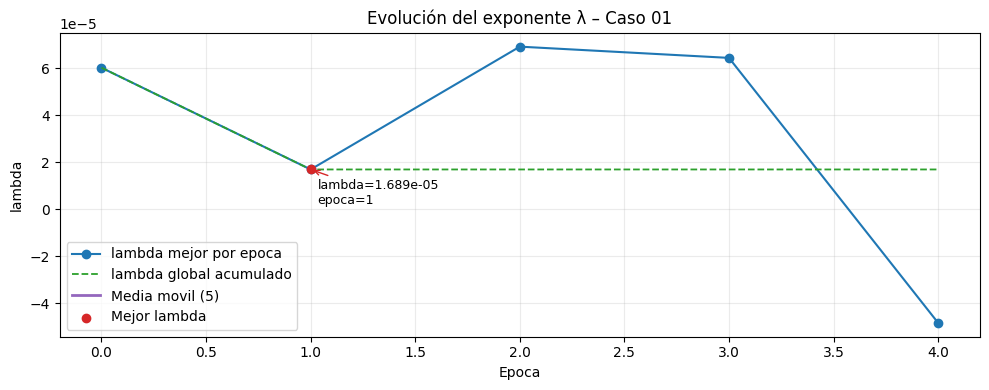

In [74]:
viz_3d = Visualizer3D(headless=cfg.headless)

_ = viz_3d.plot_lambda_evolution(
    lambda_history=metrics.best_lambda_per_epoch,
    epoch_history=metrics.epoch_history,
    title="Evolución del exponente λ – Caso 01",
    moving_average_window=5,   # opcional
)

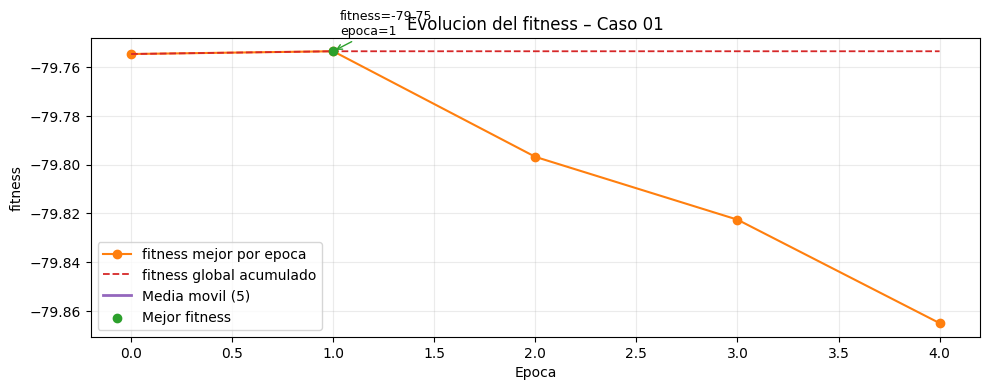

In [75]:
_ = viz_3d.plot_fitness_evolution(
    fitness_history=metrics.best_fitness_per_epoch,
    epoch_history=metrics.epoch_history,
    title="Evolucion del fitness – Caso 01",
    moving_average_window=5,
)


In [76]:
sim_builder = ReboundSim(G=cfg.G, integrator=cfg.integrator)
best_masses = tuple(results["best"]["masses"])

def _slice_vectors(vectors, count):
    if len(vectors) < count:
        raise ValueError("Config no tiene suficientes vectores iniciales")
    return tuple(tuple(float(coord) for coord in vectors[i]) for i in range(count))

r0 = _slice_vectors(cfg.r0, len(best_masses))
v0 = _slice_vectors(cfg.v0, len(best_masses))

sim = sim_builder.setup_simulation(best_masses, r0, v0)
traj = sim_builder.integrate(sim, t_end=cfg.t_end_long, dt=cfg.dt)
xyz_tracks = [traj[:, i, :3] for i in range(traj.shape[1])]


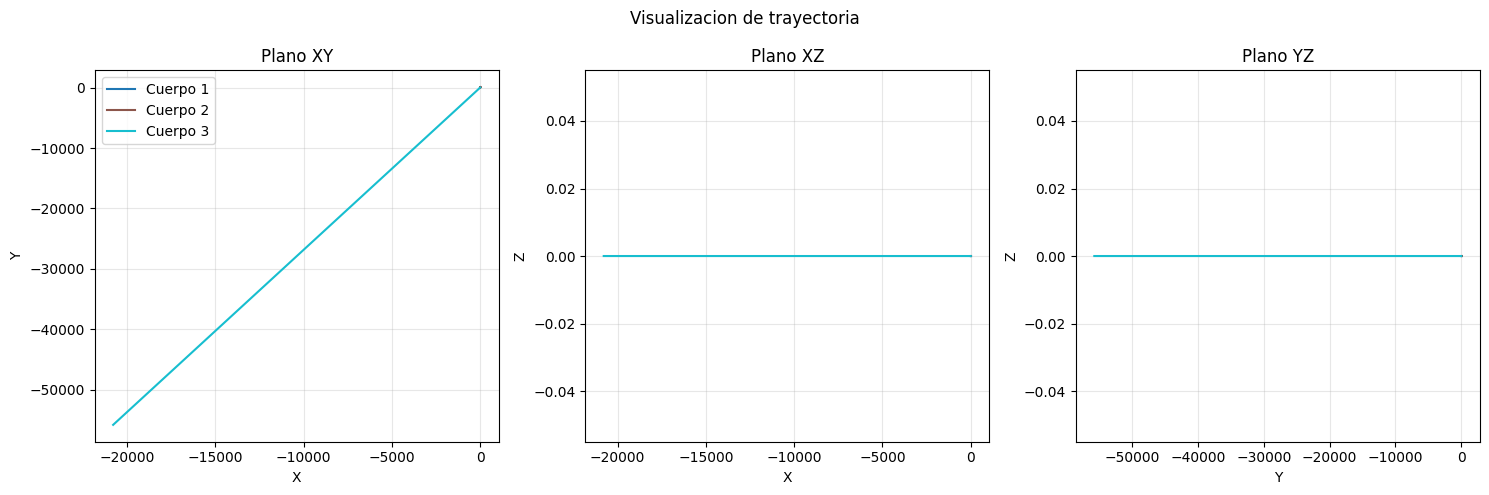

In [77]:
viz_planar = PlanarVisualizer(headless=cfg.headless)
_ = viz_planar.quick_view(xyz_tracks)  # usa una asignación para que Jupyter no duplique la figura

In [78]:
from IPython.display import HTML

import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 50  # MB

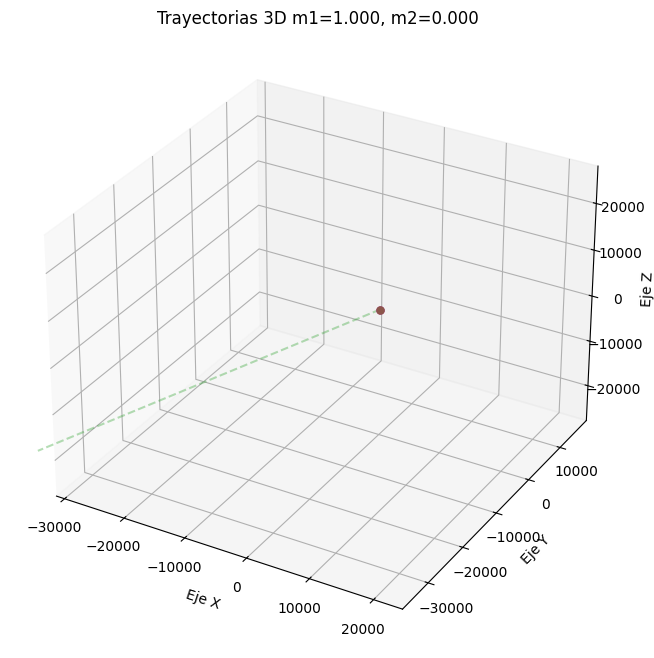

In [81]:
viz_3d = Visualizer3D(headless=False)

anim = viz_3d.animate_3d(
    trajectories=xyz_tracks,
    interval_ms=50,
    title=f"Trayectorias 3D m1={best_masses[0]:.3f}, m2={best_masses[1]:.3f}",
    total_frames=len(xyz_tracks[0]),
)
#HTML(anim.to_jshtml())  

## Exportación de animaciones

Preparamos un `FFMpegWriter`, creamos `artifacts/caso04` y guardamos los MP4 tanto de la órbita como de la comparación de masas. Ajusta `fps`, `bitrate` o `dpi` si necesitas equilibrar rapidez y calidad de render.


In [ ]:
from matplotlib.animation import FFMpegWriter  # o PillowWriter para GIF

writer = FFMpegWriter(fps=1000 // 50, bitrate=2400)   # fps = 1000/interval_ms
output_path = Path("artifacts/caso04")                # ajusta a tu gusto
output_path.mkdir(parents=True, exist_ok=True)

anim.save(output_path / "trayectoria_optima.mp4", writer=writer)

In [ ]:
anim_mass = viz_3d.plot_mass_comparison(
    original_masses=center,
    optimized_masses=best_masses,
    body_labels=[f"Cuerpo {i+1}" for i in range(len(best_masses))],
    title="Comparativa de masas (Caso 01)",
)
#HTML(anim_mass.to_jshtml())  

In [ ]:
anim_mass.save(output_path / "comparativa_masas.mp4", writer=writer)

## Reporte de tiempos

Leemos el CSV más reciente de la instrumentación, mostramos una muestra y agrupamos por sección para identificar los cuellos de botella (por ejemplo, integración larga con tres cuerpos no colineales).


In [ ]:
import pandas as pd

csv_path = latest_timing_csv()
display(f"Usando CSV: {csv_path}")

rows = read_timings_csv(csv_path)
df = pd.DataFrame(rows)
display(df.head(10))

# Estadísticas rápidas por sección
section_stats = (
    df.groupby("section")["duration_us"]
    .agg(["count", "mean", "sum"])
    .sort_values("sum", ascending=False)
)
section_stats

'Usando CSV: C:\\Users\\emicr\\Documents\\CODIGOS_FUENTES\\TrabajoTerminal\\collision_of_two_bodies\\two_body\\data\\timings\\timings_95678a96-1f1b-4e50-b1ef-7945fed17930_20251029_044441.csv'

,run_id,epoch,batch_id,individual_id,section,start_ns,end_ns,duration_us,extra
0,95678a96-1f1b-4e50-b1ef-7945fed17930,-1,-1,-1,simulation_step,18336739433700,18336739493700,60,"{'step': 0, 'dt': 0.06, 't_target': 0.06}"
1,95678a96-1f1b-4e50-b1ef-7945fed17930,-1,-1,-1,simulation_step,18336739547400,18336739560200,12,"{'step': 1, 'dt': 0.06, 't_target': 0.12}"
2,95678a96-1f1b-4e50-b1ef-7945fed17930,-1,-1,-1,simulation_step,18336739584500,18336739592900,8,"{'step': 2, 'dt': 0.06, 't_target': 0.18}"
3,95678a96-1f1b-4e50-b1ef-7945fed17930,-1,-1,-1,simulation_step,18336739608700,18336739615600,6,"{'step': 3, 'dt': 0.06, 't_target': 0.24}"
4,95678a96-1f1b-4e50-b1ef-7945fed17930,-1,-1,-1,simulation_step,18336739628200,18336739635300,7,"{'step': 4, 'dt': 0.06, 't_target': 0.3}"
5,95678a96-1f1b-4e50-b1ef-7945fed17930,-1,-1,-1,simulation_step,18336739648600,18336739655800,7,"{'step': 5, 'dt': 0.06, 't_target': 0.36}"
6,95678a96-1f1b-4e50-b1ef-7945fed17930,-1,-1,-1,simulation_step,18336739667300,18336739673400,6,"{'step': 6, 'dt': 0.06, 't_target': 0.42}"
7,95678a96-1f1b-4e50-b1ef-7945fed17930,-1,-1,-1,simulation_step,18336739684400,18336739690500,6,"{'step': 7, 'dt': 0.06, 't_target': 0.48}"
8,95678a96-1f1b-4e50-b1ef-7945fed17930,-1,-1,-1,simulation_step,18336739701800,18336739708100,6,"{'step': 8, 'dt': 0.06, 't_target': 0.54}"
9,95678a96-1f1b-4e50-b1ef-7945fed17930,-1,-1,-1,simulation_step,18336739720300,18336739727400,7,"{'step': 9, 'dt': 0.06, 't_target': 0.6}"


,count,mean,sum
section,,,
fitness_eval,2217,9.081621e+05,2013395478
lyapunov_compute,2218,9.074776e+05,2012785257
batch_eval,18,1.065656e+08,1918181606
simulation_step,53102881,1.283903e+01,681789331
ga_main,9,3.466267e+04,311964
crossover,59,1.956780e+03,115450
selection_tournament,59,8.364576e+02,49351
mutation,59,5.801525e+02,34229


Ejecutando: c:\Users\emicr\anaconda3\envs\grav2body\python.exe scripts/plot_timings.py --run-id e9f64791-4f9d-483a-a3a4-59302308bd75 --top-n 5
Graficas guardadas en C:\Users\emicr\Documents\CODIGOS_FUENTES\TrabajoTerminal\collision_of_two_bodies\two_body\reports




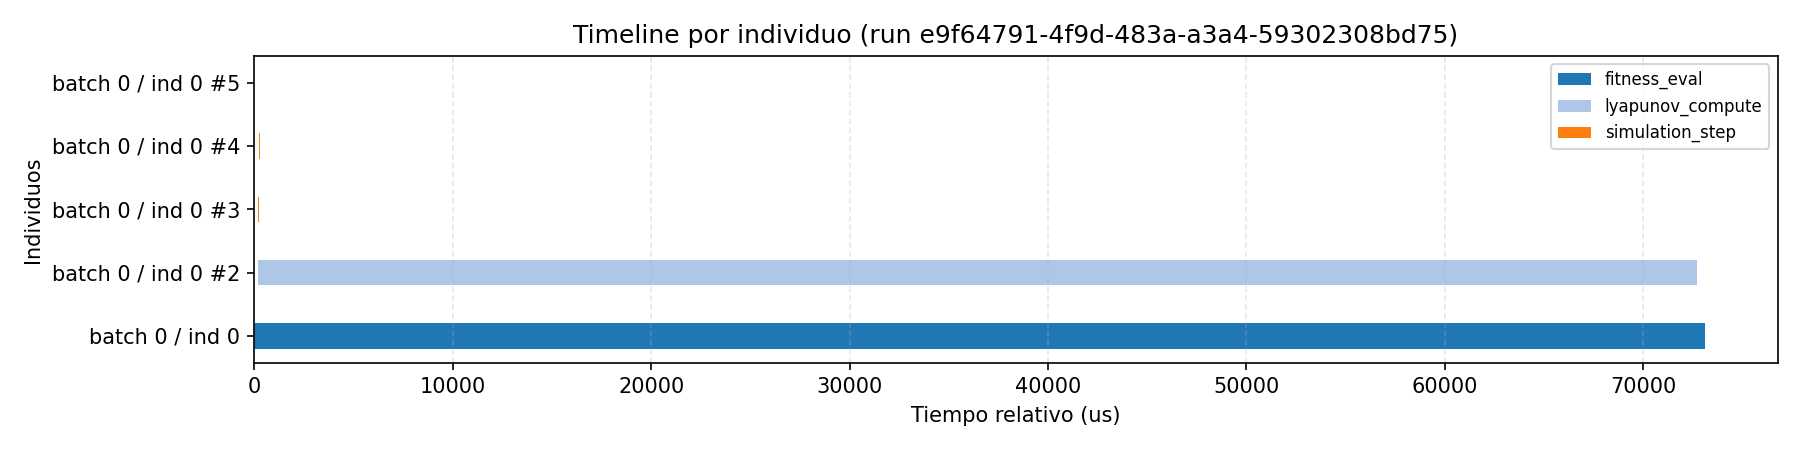

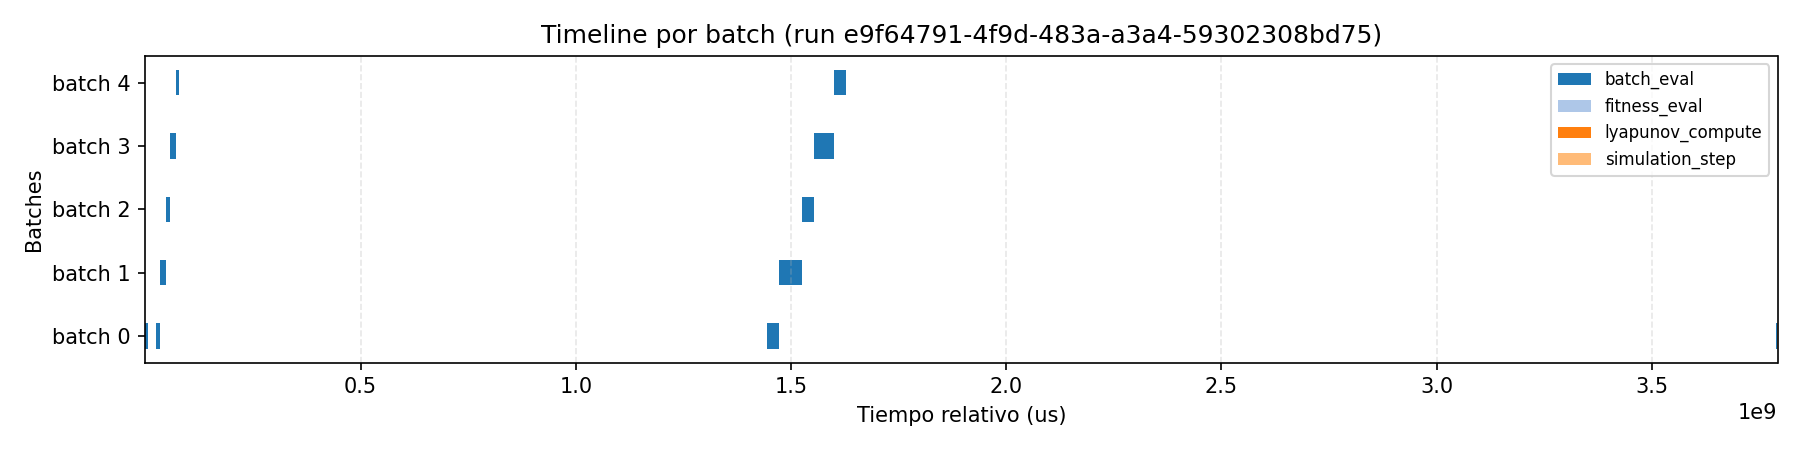

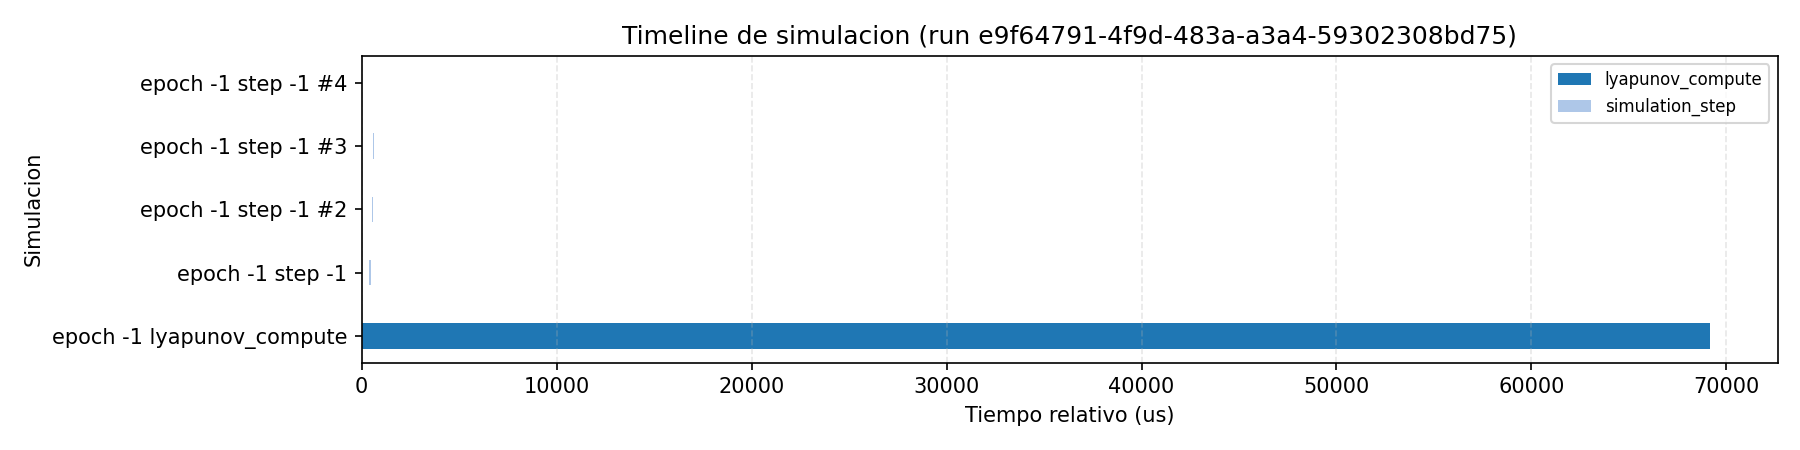

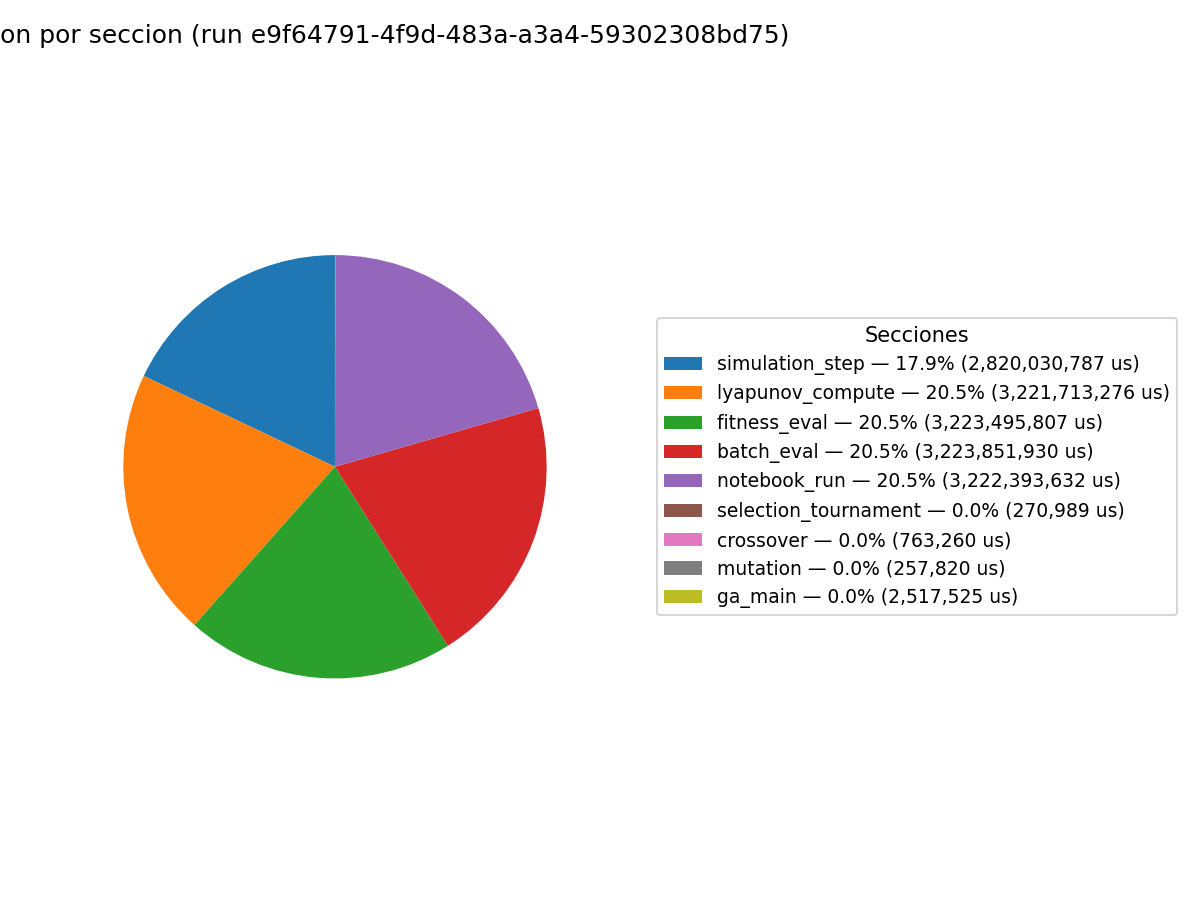

In [ ]:
import os
import subprocess
from pathlib import Path
from IPython.display import Image, display

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != "two_body" and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

env = os.environ.copy()
env["PYTHONPATH"] = str(PROJECT_ROOT)

run_id = df["run_id"].iloc[0]
cmd = [
    sys.executable,
    "scripts/plot_timings.py",
    "--run-id", str(run_id),
    "--top-n", "5",
]


print("Ejecutando:", " ".join(cmd))
result = subprocess.run(cmd, cwd=PROJECT_ROOT, env=env, text=True, capture_output=True)
print(result.stdout)
print(result.stderr)
result.check_returncode()

reports_dir = PROJECT_ROOT / "reports"

display(
    Image(filename=str(reports_dir / f"timeline_by_individual_{run_id}.png")),
    Image(filename=str(reports_dir / f"timeline_by_batch_{run_id}.png")),
    Image(filename=str(reports_dir / f"timeline_simulation_{run_id}.png")),
    Image(filename=str(reports_dir / f"pie_sections_{run_id}.png")),
)


In [ ]:
# from pathlib import Path
# 
# 
# output_path = Path("artifacts/animations/caso01_orbit.gif")
# output_path2 = Path("artifacts/animations/caso01_comparasion.gif")
# output_path.parent.mkdir(parents=True, exist_ok=True)
# 
# anim.save(
#     output_path,
#     writer="pillow",
#     fps=20,
#     dpi=100,          # opcional
# )
# 
# print(f"Animación 3D guardada en {output_path}")
# 